# Example: Simulating a MAST-U shot using input data from EFIT++ (via pyUDA)

This example notebook will show how to carry out a **dynamic (time-dependent)** forward Grad-Shafranov equilibrium simulation for MAST-U shots using FreeGSNKE. 

**Note**: This notebook can only be run with access to a UDA client (or run via the Freia cluster at UKAEA). 

## Import packages

In [1]:
import numpy as np
import pickle
import time
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path
from copy import deepcopy

# freegs4e/freegsnke modules (other may be needed later)
import freegs4e
from freegsnke import equilibrium_update, GSstaticsolver, mastu_tools

In [2]:
# changes working directory (comment out if not needed)
import os
os.chdir("freegsnke/examples") 
print(os.getcwd())

/home/kpentlan/Documents/freegsnke/examples


## Select MAST-U shot that you wish to simulate

In [3]:
# MAST-U shot number (make sure it's a valid shot with EFIT++ equilibrium reconstruction data!)
shot = 45292

## Build the MAST-U machine

Next, we build the MAST-U machine object. This can be done using the geometry data from a particular shot number via the 'get_machine_data' function below.

FreeGSNKE requires the following envirnoment variables in order to build the machine: ACTIVE_COILS_PATH, PASSIVE_COILS_PATH, WALL_PATH, LIMITER_PATH, PROBE_PATH. 

Note 1: There are two options used for building the active coils in FreeGSNKE. The first sets up **symmetric** coils where the corresponding up/down coils in MAST-U (e.g. P4_upper and P4_lower) are wired **in series** and therefore will be assigned the same current value later. The second option sets up **non-symmetric** coils in which the up/down coils are modelled independently and can be assigned **different** currents (i.e. they are **not wired in series**). Set the 'symmetric_machine' parameter to either 'True' or 'False' to toggle this setting. We use the **non-symmetric** setting here as the coil currents in EFIT++ are calculated independently (though you may test out the symmetric case too to see the differences). 

Note 2: The magnetic probes are not used in this script (see "example1c" for how to use them). 

In [4]:
# This function will pull machine geoemtry data from the shot number.
# 'split_passive=True' means the passives structures will be modelled as parallelograms with current
# distributed evenly over their cross-sectional area (which is reccomended), setting to 'False' will
# model them as point sources (less accurate for parallelograms with large surface areas).
# mastu_tools.get_machine_data(save_path="../machine_configs/MAST-U", shot=shot, split_passives=True)

In [5]:
# set paths (choose symmetric or non-symmetric active coils)
symmetric_machine = True
if symmetric_machine:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils.pickle"
else:
    os.environ["ACTIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_active_coils_nonsym.pickle"
os.environ["PASSIVE_COILS_PATH"] = f"../machine_configs/MAST-U/MAST-U_passive_coils.pickle"
os.environ["WALL_PATH"] = f"../machine_configs/MAST-U/MAST-U_wall.pickle"
os.environ["LIMITER_PATH"] = f"../machine_configs/MAST-U/MAST-U_limiter.pickle"
os.environ["PROBE_PATH"] = f"../machine_configs/MAST-U/MAST-U_magnetic_probes.pickle"

# now the machine can actually be built
from freegsnke import build_machine
tokamak = build_machine.tokamak()

## Load the required input data from the EFIT++ reconstructions
Here, we load the parameters generated by the EFIT++ reconstruction that we'll need.

In [6]:
# initialise the pyuda client to access the data
import pyuda
client = pyuda.Client()

# load the parameters
Ip, fvac, alpha, beta, alpha_logic, beta_logic, currents_sym, currents_nonsym, _ = mastu_tools.load_static_solver_inputs(
    client=client,        # pyuda client
	shot=shot,            # shot number
	zero_passives=False   # set passive structure currents to zero? (True or False)
    )

We now load the shot times at which the EFIT++ reconstructions were carried out (which correspond to the above data) and check which time slices successfully converged. This is important because we might need to exclude those that failed to converge (typically these occur during the ramp-up and ramp-down of the plasma). 


In [7]:
# load the efit reconstruction timestamps and convergence status
# Note: efit_times that have efit_status=-1 did not converge so we will exclude those time slices
efit_times, efit_status = mastu_tools.load_efit_times_and_status(client=client, shot=shot)
print(f"The efit simulation window was: [{efit_times[0]},{efit_times[-1]}] seconds.")

# figure out which time slices did not converge
time_indices = np.where(efit_status == 1)[0]
time_slices_excluded = np.where(efit_status == -1)[0]
print(f"{len(time_slices_excluded)} time slices (out of total {len(efit_times)}) should probably be excluded from simulation.")
print(f"The offending time slices are: {efit_times[time_slices_excluded]} seconds.")

times = efit_times[time_indices]  # these are the slices we simulate
print(f"Total time slices to be simulated = {len(times)}. The acceptable simulation window is [{times[0]}, {times[-1]}] seconds.")


The efit simulation window was: [0.02,0.705] seconds.
11 time slices (out of total 133) should probably be excluded from simulation.
The offending time slices are: [0.02  0.03  0.04  0.05  0.055 0.065 0.07  0.075 0.08  0.085 0.09 ] seconds.
Total time slices to be simulated = 122. The acceptable simulation window is [0.095, 0.705] seconds.


In [8]:
# cut off some specific times
# times = times[11:-5]

The EFIT++ input data typically has a relatively low temporal resolution (approx. 0.005s) and so, to use it within a dynamic FreeGSNKE simulation, we need to interpolate/smooth some of the quantities out over time. This is required because the dynamic solver will run with a significantly smaller timestep than the data is available at (the timestep in FreeGSNKE will need to be smaller than the unstable vertical instability timescale from the starting equilibrium). 

Here we will do some interpolation and show the data vs. the smoothed versions. The interpolation parameters can be tweaked by hand.

In [9]:
# start and end times
t_start = 0.1
t_final = 0.68
# t_start = times[0]
# t_final = times[-1]

smooth_Ip = mastu_tools.interpolate_data(
    times=efit_times,
    data=Ip,
    t_start=t_start, 
    t_final=t_final,
    order=7          # polynomial order
    )

smooth_fvac = mastu_tools.interpolate_data(
    times=efit_times,
    data=fvac[:],
    t_start=t_start, 
    t_final=t_final,
    order=4
    )

smooth_alpha_0 = mastu_tools.interpolate_data(
    times=efit_times,
    data=alpha[:,0],
    t_start=t_start, 
    t_final=t_final,
    order=6
    )

smooth_alpha_1 = mastu_tools.interpolate_data(
    times=efit_times,
    data=alpha[:,1],
    t_start=t_start, 
    t_final=t_final,
    order=8
    )

smooth_beta_0 = mastu_tools.interpolate_data(
    times=efit_times,
    data=beta[:,0],
    t_start=t_start, 
    t_final=t_final,
    order=8
    )

smooth_beta_1 = mastu_tools.interpolate_data(
    times=efit_times,
    data=beta[:,1],
    t_start=t_start, 
    t_final=t_final,
    order=8
    )

Here we plot the fits against the data, they polynomial `order` parameter can be tweaked if needed. 

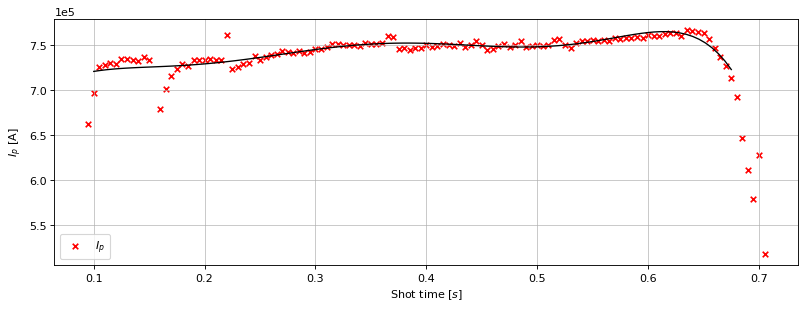

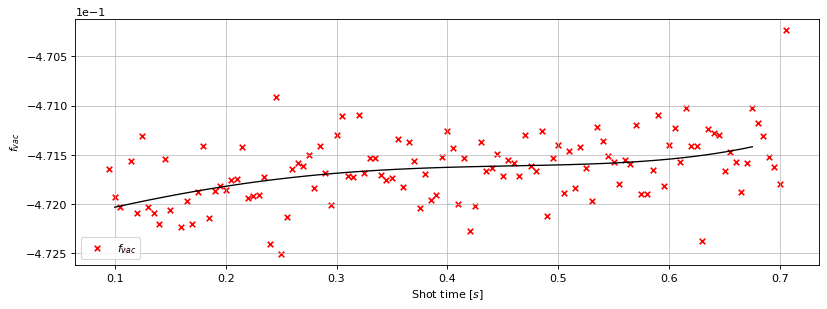

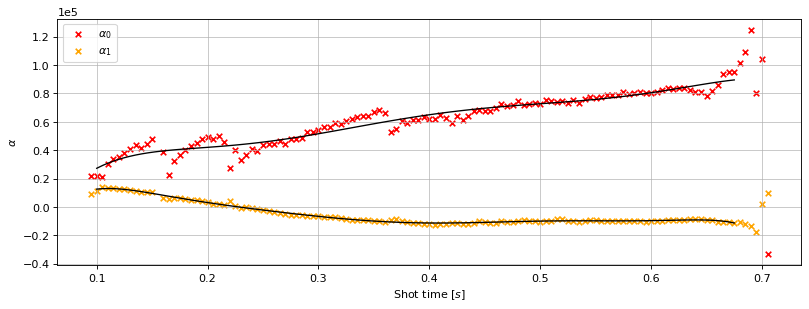

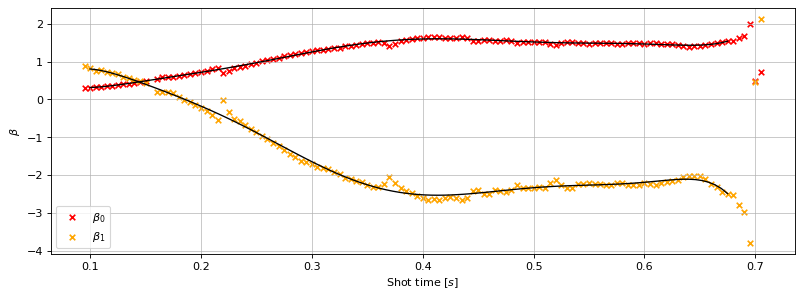

In [10]:
fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.scatter(times, Ip[time_indices], color='r', marker='x', s=25, label=r"$I_p$")
ax1.plot(*smooth_Ip.linspace(), color='k', linewidth=1.2)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$I_p$ [A]')
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "lower left")

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.scatter(times, fvac[time_indices], color='r', marker='x', s=25, label=r"$f_{vac}$")
ax1.plot(*smooth_fvac.linspace(), color='k', linewidth=1.2)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$f_{vac}$')
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "lower left")

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.scatter(times, alpha[time_indices,0], color='r', marker='x', s=25, label=r"$\alpha_0$")
ax1.scatter(times, alpha[time_indices,1], color='orange', marker='x', s=25, label=r"$\alpha_1$")
ax1.plot(*smooth_alpha_0.linspace(), color='k', linewidth=1.2)
ax1.plot(*smooth_alpha_1.linspace(), color='k', linewidth=1.2)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$\alpha$')
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "upper left")

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)

ax1.scatter(times, beta[time_indices,0], color='r', marker='x', s=25, label=r"$\beta_0$")
ax1.scatter(times, beta[time_indices,1], color='orange', marker='x', s=25, label=r"$\beta_1$")
ax1.plot(*smooth_beta_0.linspace(), color='k', linewidth=1.2)
ax1.plot(*smooth_beta_1.linspace(), color='k', linewidth=1.2)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$\beta$')
ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "lower left")

## Load the directly measured currents and voltages
Next, we need to load the currents and voltages that are recorded on the active coils in MAST-U. 

These currents will be used to simulate the starting equilibrium (in conjuction with the passive strucutre currents from EFIT++) shortly. 

Note that there is no recorded voltage for the P6 coil - this will need to be inferred by a PID controller later on. 

In [11]:
# extract data
att_dict, data = mastu_tools.load_currents_voltages_and_TS_signals(client=client, shot=shot)

# store coil names
coil_names = list(att_dict.keys())

# mini function to print keys in the dictionary
def print_tree(d, indent=0):
    """Recursively print dictionary keys in a tree-like format."""
    for key, value in d.items():
        print(" " * indent + str(key))
        if isinstance(value, dict):  # If value is a dictionary, recurse
            print_tree(value, indent + 4)
            
print_tree(data)

Voltage not found for coil P6.
Finished reading, all data in place.
Interpolating and storing data...
Data stored.
time
D1
    V
    full_time
    fullV
    units
    D1U
        C
        full_time_C
        fullC
        units_C
    D1L
        C
        full_time_C
        fullC
        units_C
D2
    V
    full_time
    fullV
    units
    D2U
        C
        full_time_C
        fullC
        units_C
    D2L
        C
        full_time_C
        fullC
        units_C
D3
    V
    full_time
    fullV
    units
    D3U
        C
        full_time_C
        fullC
        units_C
    D3L
        C
        full_time_C
        fullC
        units_C
D5
    V
    full_time
    fullV
    units
    D5U
        C
        full_time_C
        fullC
        units_C
    D5L
        C
        full_time_C
        fullC
        units_C
D6
    V
    full_time
    fullV
    units
    D6U
        C
        full_time_C
        fullC
        units_C
    D6L
        C
        full_time_C
        fullC
 

/tmp/ipykernel_9763/1651652469.py:6: RuntimeWarning: invalid value encountered in divide
  resis_data = np.sum(np.nan_to_num(data['TS']['full_T'], posinf=0)*np.nan_to_num(data['TS']['full_N'], posinf=0),axis=1)/np.sum(np.nan_to_num(data['TS']['full_N'], posinf=0),axis=1)


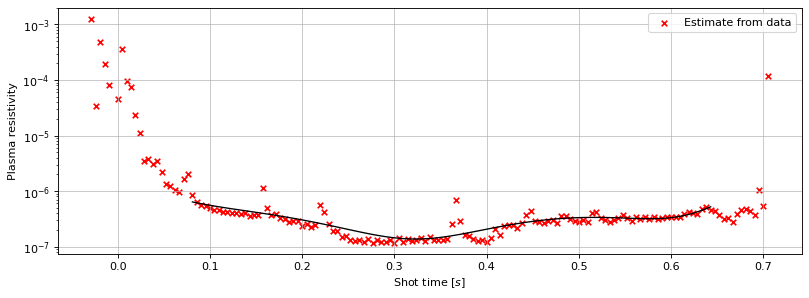

In [12]:
# plot estimated plasma resistivity and smoothed version

t_start = 0.0810493
t_final = 0.6477157

resis_data = np.sum(np.nan_to_num(data['TS']['full_T'], posinf=0)*np.nan_to_num(data['TS']['full_N'], posinf=0),axis=1)/np.sum(np.nan_to_num(data['TS']['full_N'], posinf=0),axis=1)

smooth_resistivity = mastu_tools.interpolate_data(
    times=data['TS']['times'],
    data=2.65*1e-3*resis_data**(-1.5),
    t_start=t_start, 
    t_final=t_final,
    order=6
    )

fig1, ax1 = plt.subplots(1, 1, figsize=(12,4), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.scatter(data['TS']['times'], 2.65*1e-3*resis_data**(-1.5), color='r', marker='x', s=25, label=r"Estimate from data")
ax1.plot(*smooth_resistivity.linspace(), color='k', linewidth=1.2)
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'Plasma resistivity')
ax1.set_yscale('log')
# ax1.ticklabel_format(axis='y', scilimits=(0,0))
ax1.legend(loc = "upper right")

## Static solve over the entire shot (for comparison later)
Here, we'll solve the static GS problem on each time slice independently using the:
- EFIT++ profiles information (smoothed). 
- analysed active coil currents (except for P6 which will come from EFIT++).
- EFIT++ passive structure currents. 

We'll use the shape targets from these equilibria later on and compare them to what comes out of the dynamic solver in FreeGSNKE. 

In [13]:
# equilibrium object (note that both nx and ny have to be of the form 2**n + 1 with n being an integer)
eq = equilibrium_update.Equilibrium(
tokamak=tokamak,             # sets up the object with the MAST-U tokamak
Rmin=0.06, Rmax=2.0,         # computational grid radial limits (same as EFIT++)
Zmin=-2.2, Zmax=2.2,         # computational grid vertical limits (same as EFIT)
nx=65,                       # number of grid points in the radial direction
ny=65,                       # number of grid points in the vertical direction
psi=None                     # initial guess for the plasma flux (can provide one if available)
) 

plasma_psi = deepcopy(eq.plasma_psi)

In [14]:
# static solver object (used for solving later on)
solver = GSstaticsolver.NKGSsolver(eq)  

In [15]:
# solve at each time step
from freegsnke import jtor_update # for initialising the profile object
from copy import deepcopy

# carry out the simulation and store some quantities of interest
freegsnke_output_data = dict()
for i, t in enumerate(times):

    # strings for dictionary keys
    time_str = str(t).replace(".", "")
    name = f"shot_{shot}_time_{time_str}"

    # start timer
    start_time = time.time()

    print(f"-----Solving equilibrium for shot {shot} at time {t}-----")
    
    # # initialise profile object (smoothed EFIT++ input data)
    # profiles = jtor_update.Lao85(
    #     eq=eq,                                                 # equilibrium object
    #     limiter=tokamak.limiter,                               # plasma limiter
    #     Ip=smooth_Ip(t),                                       # total plasma current
    #     fvac=smooth_fvac(t),                                   # f vacuum parameter (R*Bt)
    #     alpha=[smooth_alpha_0(t), smooth_alpha_1(t)],          # p' profile coefficients
    #     beta=[smooth_beta_0(t), smooth_beta_1(t)],             # p' profile coefficients
    #     alpha_logic=True,                      # logic parameters from above
    #     beta_logic=True,
    # )

    # initialise profile object (raw EFIT++ input data)
    profiles = jtor_update.Lao85(
        eq=eq,                                                 # equilibrium object
        limiter=tokamak.limiter,                               # plasma limiter
        Ip=Ip[time_indices[i]],                                # total plasma current
        fvac=fvac[time_indices[i]],                            # f vacuum parameter (R*Bt)
        alpha=alpha[time_indices[i],:],                        # p' profile coefficients
        beta=beta[time_indices[i],:],                          # FF' profile coefficients
        alpha_logic=bool(alpha_logic[time_indices[i]]),        # logic parameters from above
        beta_logic=bool(beta_logic[time_indices[i]]),
    )
        
    # set all currents (active and passive) with EFIT++ values
    # checks if machine is up/down symmetric or not
    if symmetric_machine:
        for coil in currents_sym.keys():
            eq.tokamak[coil].current = currents_sym[coil][time_indices[i]]
    else:
        for coil in currents_nonsym.keys():
            eq.tokamak[coil].current = currents_nonsym[coil][time_indices[i]]
        
    # replace EFIT++ active coil currents (except P6) with AMC currents
    currents = mastu_tools.get_AMC_currents(t=t, att_dict=att_dict, data=data)
    for j, coil in enumerate(list(eq.tokamak.getCurrents().keys())[:11]):
        eq.tokamak[coil].current = currents[j]
        
    # carry out the standard forward solve
    eq.plasma_psi = eq.create_psi_plasma_default()
    tol = 1e-6
    solver.solve(eq=eq,
                profiles=profiles,
                constrain=None,
                target_relative_tolerance=tol,
                max_solving_iterations=50,  
                )
    
    # stop timer
    end_time = time.time()

    # store data
    freegsnke_output_data[name] = deepcopy(eq),

print("-----SIMULATIONS COMPLETE!-----")

-----Solving equilibrium for shot 45292 at time 0.095-----
-----Solving equilibrium for shot 45292 at time 0.1-----
-----Solving equilibrium for shot 45292 at time 0.105-----
-----Solving equilibrium for shot 45292 at time 0.11-----
-----Solving equilibrium for shot 45292 at time 0.115-----
-----Solving equilibrium for shot 45292 at time 0.12-----
-----Solving equilibrium for shot 45292 at time 0.125-----
-----Solving equilibrium for shot 45292 at time 0.13-----
-----Solving equilibrium for shot 45292 at time 0.135-----
-----Solving equilibrium for shot 45292 at time 0.14-----
-----Solving equilibrium for shot 45292 at time 0.145-----
-----Solving equilibrium for shot 45292 at time 0.15-----
-----Solving equilibrium for shot 45292 at time 0.16-----
-----Solving equilibrium for shot 45292 at time 0.165-----
-----Solving equilibrium for shot 45292 at time 0.17-----
-----Solving equilibrium for shot 45292 at time 0.175-----
-----Solving equilibrium for shot 45292 at time 0.18-----
-----So

/home/kpentlan/Documents/freegsnke/freegsnke/GSstaticsolver.py:515: UserWarning: Forward solve failed to converge to requested relative tolerance of 1e-06 with less than 50 iterations. Last relative psi change: 0.09731223009111022.
  warnings.warn(


## Set calibrated resistances and inductances
The (geometrically) calculated resistances and inductances for MAST-U in FreeGSNKE may not work exactly as required during a dynamic FreeGSNKE simulation. This is because they have not yet been calibrated (using vacuum shot data or via other means)...

Here we'll extract some previously calibrated values directly from file. Note that the P6 coil will use its default (geometric) value. 

In [16]:
from freegsnke import machine_config

# set active coil resistances (except P6 coil)
machine_config.coil_resist[0:11] = np.array([2.22482036e-02, 1.79351241e-02, 2.61017043e-02, 2.41645251e-02,
       3.32142836e-02, 3.79537074e-02, 9.89923757e-02, 6.03935761e-02,
       7.06578790e-02, 1.39307173e-02, 1.44515806e-02])

# set active coil inductances (except P6 coil)
machine_config.coil_self_ind[0:11, 0:11] = np.array([
    [0.00442211, 0.00126295, 0.00052302, 0.00024935, 0.00019594, 0.00041023, 0.00029931, 0.00033365, 0.000348  , 0.0003987 , 0.00041158],
    [0.00126295, 0.00131596, 0.00036335, 0.00017505, 0.00011786, 0.00023451, 0.00013242, 0.00019235, 0.00015471, 0.0001823 , 0.00015324],
    [0.00052302, 0.00036335, 0.00293587, 0.0008323 , 0.00040269, 0.00056448, 0.00032386, 0.00048481, 0.00038816, 0.00028727, 0.00023873],
    [0.00024935, 0.00017505, 0.0008323 , 0.00230529, 0.00078785, 0.00074808, 0.0004589 , 0.00058858, 0.0005081 , 0.00038012, 0.00028785],
    [0.00019594, 0.00011786, 0.00040269, 0.00078785, 0.00363142, 0.00091166, 0.00096223, 0.00100154, 0.00092452, 0.00058317, 0.00045576],
    [0.00041023, 0.00023451, 0.00056448, 0.00074808, 0.00091166, 0.00443611, 0.00118603, 0.0019753 , 0.00155791, 0.00134748, 0.0008758 ],
    [0.00029931, 0.00013242, 0.00032386, 0.0004589 , 0.00096223, 0.00118603, 0.01476804, 0.00269449, 0.00341989, 0.00231967, 0.00195166],
    [0.00033365, 0.00019235, 0.00048481, 0.00058858, 0.00100154, 0.0019753 , 0.00269449, 0.00661903, 0.0037269 , 0.00271148, 0.00160164],
    [0.000348  , 0.00015471, 0.00038816, 0.0005081 , 0.00092452, 0.00155791, 0.00341989, 0.0037269 , 0.00844731, 0.00351691, 0.00219511],
    [0.0003987 , 0.0001823 , 0.00028727, 0.00038012, 0.00058317, 0.00134748, 0.00231967, 0.00271148, 0.00351691, 0.00647608, 0.00248017],
    [0.00041158, 0.00015324, 0.00023873, 0.00028785, 0.00045576, 0.0008758 , 0.00195166, 0.00160164, 0.00219511, 0.00248017, 0.00896681]
    ])

# coil_resist = machine_config.coil_resist
# coil_ind = machine_config.coil_self_ind

## Build initial condition for dynamic solver
We need to choose a particular time slice from which to begin our dynamic simulation. 

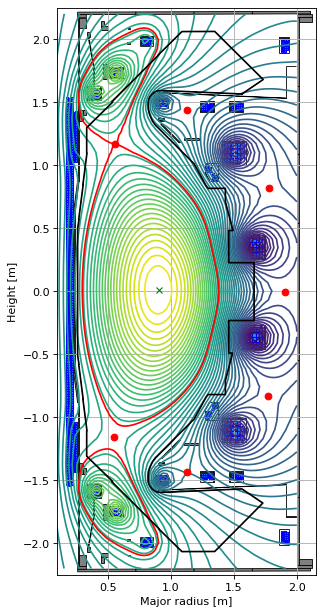

In [17]:
# copy the equilibrium we want to start with
t = 0.2
time_str = str(t).replace(".", "")
EQ = deepcopy(freegsnke_output_data[f'shot_{shot}_time_{time_str}'][0])
PROFILES = deepcopy(freegsnke_output_data[f'shot_{shot}_time_{time_str}'][0]._profiles)

# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
EQ.plot(axis=ax1, show=False)
EQ.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Initialise the nonlinear solver
We're now ready to initialise the evolutive solver in FreeGSNKE. These parameters will form the initial conditions for the nonlinear solver. Some of them (e.g. profiles, resistivity, and later the voltages) will be modified at certain timesteps throughout the simulation. 

In [18]:
from freegsnke import nonlinear_solve

dynamic_solver = nonlinear_solve.nl_solver(
    eq=EQ,                          # initial equilibrium
    profiles=PROFILES,              # initial profiles
    full_timestep=2e-4,             # temporary timestep (will change later)
    automatic_timestep = (1/9,1/6), # decides how to set the 'full_timestep' wrt the vertical instability timescale
    plasma_resistivity=4.5e-7,      # initial plasma resistivity
    min_dIy_dI=1e-5,
    max_mode_frequency=5e3,
    # custom_coil_resist=coil_resist,
    # custom_self_ind=coil_ind
    )
dIydI = dynamic_solver.dIydI

# initialise the solver with the initial eq and profiles
dynamic_solver.initialize_from_ICs(EQ, PROFILES)

Input 'max_mode_frequency' corresponds to 83 independent passive structure normal modes (in addition to the 12 active coils).
Linearising with respect to the currents - this may take a minute or two.
Mode removal is ON: the input 'min_dIy_dI' corresponds to keeping 95 out of the original 95 metal modes.
The linear growth rate of this equilibrium corresponds to a characteristic timescale of [0.01269634] s.
The solver's timestep has been reset at 0.001410704086870406 using the calculated linear growth rate and the provided values for the input automatic_timestep.


## Run the time-dependent simulation

We're almost ready to run the evolutive simulation. An outline of the process at each time step $t$ is as follows:

1. **Set the voltages**
    - Extract the voltages at time $t$ for all the coils **except P6**. The function called will average the voltage data for each coil from MAST-U over $[t, t + dt]$ to smooth out any spikes. 
    - P6 is the vertical control coil and the data form MAST-U is unavailable so we need to control it ourselves. This is done dynamically at every time step via a PID contol function. 
    - The voltages may need to be 'shifted' across the duration of the shot so there is an option for that (which is set to None here).

2. **Adjust the plasma resistivity if required**
    - Every few time steps, the plasma resistivity is dynamically adjusted using another PID controller. This function looks forward (at the smooth plasma current $I_p$ data).

3. **Adjust the plasma current density profile parameters**
    - Every time step, the plasma current density profile parameters are updated according to the smoothed profiles fitted above.

4. **Carry out the time step using FreeGSNKE**
    - This call will solve the GS equation in conjunction with the circuit equations using all of the preceding data.

5. **Record input/output data**
    - Store the data from each time step before calling the next.

In [ ]:
# storage lists for data collection 
history_times = [t]
history_eqs = [deepcopy(dynamic_solver.eq1)]
history_full_currents = [dynamic_solver.currents_vec[:-1]]
history_Ip = [dynamic_solver.profiles1.Ip]
history_voltages = []
history_plasma_resistivity = [dynamic_solver.plasma_resistivity]
history_jz = [np.mean(dynamic_solver.profiles1.jtor/dynamic_solver.profiles1.Ip * eq.Z)] # for vertical controller

# total number of time steps
N = 75   # 480

: 

In [20]:
for i in range(0, N):
    
    print(f"-----Solving for time {np.round(t,5)}s (step {i+1}/{N})-----")
    
    # prepare voltages
    input_voltages = 1.0*mastu_tools.get_XDC_voltages(t=t, dt=dynamic_solver.dt_step, att_dict=att_dict, data=data, nsteps=1)
    input_voltages[-1] = mastu_tools.vertical_controller(
        dt=dynamic_solver.dt_step, 
        target=0.0,
        history=history_jz, 
        k_prop=-20000,
        k_int=0, 
        k_deriv=-50,
        prop_exponent=1.0,
        prop_error=1e-3,
        deriv_threshold=50, 
        int_factor=0.98, 
        Ip=dynamic_solver.profiles1.Ip,
        Ip_ref=750e3, 
        derivative_lag=1, 
    )
    
    # shift if needed
    voltage_shifts = None
    # voltage_shifts = np.array([-3, 0, 3., -5, -5, 9, -3, -4, -5, +7, 3, 0])
    if voltage_shifts is not None:
        input_voltages -= voltage_shifts
        
    # adjust plasma resisitvity (every few time steps)
    if (i%5)==4:
        del_resistivity = mastu_tools.plasma_resistivity_controller(
            t=t,
            dt=dynamic_solver.dt_step, 
            target=smooth_Ip(t),
            history=history_Ip,   
            k_prop=1.5e-12,
            k_int=0, 
            k_deriv=1.2e-14,
            prop_exponent=1.0,
            prop_error=1.0,
            deriv_threshold=1e-7, 
            int_factor=0.98, 
            derivative_lag=4, 
            shift_pred=True,
            Ip_func=smooth_Ip,
        )
        adj_plasma_resistivity = dynamic_solver.plasma_resistivity + del_resistivity
        # history_plasma_resistivity.append(adj_plasma_resistivity)
    else:
        adj_plasma_resistivity = None
        # history_plasma_resistivity.append(dynamic_solver.plasma_resistivity)    
    
    # adjust plasma parameters
    pars_dict = {'alpha':[smooth_alpha_0(t), smooth_alpha_1(t)], 'beta':[smooth_beta_0(t), smooth_beta_1(t)]}

    # carry out the time step
    dynamic_solver.nlstepper(
                    plasma_resistivity = adj_plasma_resistivity,
                    active_voltage_vec = input_voltages,   # assign active voltages
                    profile_parameters = pars_dict,        # assign profile parameters
                    linear_only = False,                   # linear or nonlinear solve?
                    target_relative_tol_currents=1e-2,     # relative tolerance in the currents required for convergence
                    target_relative_tol_GS=1e-2,           # relative tolerance in the plasma flux required for convergence
                    working_relative_tol_GS=1e-2/10,       # tolerance used when solving all static GS problems, expressed in terms of the change in the plasma flux due to 1 timestep of evolution
                    verbose = 0,                           # print some output?
                ) 
    
    # update time step
    t += dynamic_solver.dt_step

    print(f"----------P6 voltage = {np.round(input_voltages[-1],3)} [V], Avg. jtor height = {np.round(history_jz[-1],5)} [m], P6 current = {np.round(dynamic_solver.currents_vec[11],1)} [A]-----")
    print(f"----------Ip = {np.round(dynamic_solver.profiles1.Ip/1000,1)} [A], Smoothed Ip = {np.round(smooth_Ip(t) / 1000, 1)} [A], Plasma resistivity = {np.round(dynamic_solver.plasma_resistivity, 9)}----------")

    # store inputs/outputs
    history_times.append(t)
    history_eqs.append(deepcopy(dynamic_solver.eq1))
    history_full_currents.append(dynamic_solver.currents_vec[:-1])
    history_Ip.append(dynamic_solver.profiles1.Ip)
    history_voltages.append(input_voltages)
    history_plasma_resistivity.append(dynamic_solver.plasma_resistivity)    
    history_jz.append(np.mean(dynamic_solver.profiles1.jtor/dynamic_solver.profiles1.Ip * eq.Z))


-----Solving for time 0.2s (step 1/100)-----
----------P6 voltage = -24.9 [V], Avg. jtor height = 0.00127 [m], P6 current = -233.1 [A]-----
----------Ip = 742.9 [A], Smoothed Ip = 729.6 [A], Plasma resistivity = 4.5e-07----------
-----Solving for time 0.20141s (step 2/100)-----
----------P6 voltage = 24.661 [V], Avg. jtor height = 0.00036 [m], P6 current = -153.9 [A]-----
----------Ip = 744.1 [A], Smoothed Ip = 729.8 [A], Plasma resistivity = 4.5e-07----------
-----Solving for time 0.20282s (step 3/100)-----
----------P6 voltage = -4.373 [V], Avg. jtor height = 0.00031 [m], P6 current = -147.6 [A]-----
----------Ip = 746.0 [A], Smoothed Ip = 729.9 [A], Plasma resistivity = 4.5e-07----------
-----Solving for time 0.20423s (step 4/100)-----
----------P6 voltage = 15.66 [V], Avg. jtor height = -8e-05 [m], P6 current = -104.4 [A]-----
----------Ip = 746.9 [A], Smoothed Ip = 730.1 [A], Plasma resistivity = 4.5e-07----------
-----Solving for time 0.20564s (step 5/100)-----
----------P6 volta

: 

: 

In [ ]:
# lists to arrays
history_Ip = np.array(history_Ip)
history_full_currents = np.array(history_full_currents)
history_voltages = np.array(history_voltages)
history_plasma_resistivity = np.array(history_plasma_resistivity)
history_times = np.array(history_times)

## Results

Below, we'll compare inputs and outputs to the evolutive simulation with those from MAST-U (both from EFIT++ and the analysed data signals).

### Plasma current and plasma resistivity

Here, we plot the total plasma current (left panel) from the evolutive simulation (vs. the EFIT++ total plasma current) and the plasma resistivity (right panel) used in the evolutive simulation (vs. smoothed Thomson scattering data.)

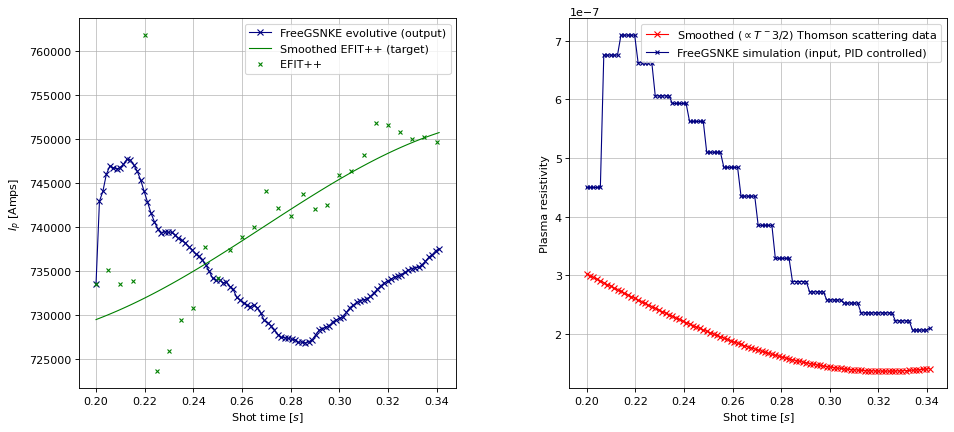

In [ ]:
efit_times_mask = (efit_times >= min(history_times))*(efit_times <= max(history_times))

# plots
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=80)
plt.subplots_adjust(wspace=0.3)  # Adjust the horizontal space between subplots

ax1.grid(zorder=0, alpha=0.75)

ax1.plot(history_times, history_Ip, color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)')
ax1.plot(history_times, smooth_Ip(history_times), color='g',  linewidth=1, marker=None, markersize=None, label='Smoothed EFIT++ (target)')
ax1.plot(efit_times[efit_times_mask], Ip[efit_times_mask], color='g',  linewidth=0, marker='x', markersize=4, label='EFIT++ ')
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_ylabel(r'$I_p$ [Amps]')
ax1.set_axisbelow(True)
ax1.legend()

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(history_times, smooth_resistivity(history_times), color='r',  linewidth=1, marker='x', markersize=5, label=r"Smoothed ($\propto T^-3/2$) Thomson scattering data")
ax2.plot(history_times, history_plasma_resistivity, color='navy',  linewidth=1, marker='x', markersize=4, label="FreeGSNKE simulation (input, PID controlled)")
ax2.set_xlabel(r'Shot time [$s$]')
ax2.set_ylabel(r'Plasma resistivity')
# ax2.set_yscale('log')
ax2.set_axisbelow(True)
ax2.legend()

plt.show()


### Voltages and currents

Here, we plot the input voltages (left panels) that go into the evolutive FreeGSNKE simulation (vs. the XDC voltages from MAST-U) and the currents (right panels) returned by the evolutive solver (vs. the AMC currents from MAST-U). Note that there is no P6 XDC voltage data and the voltage used in the evolutive simulation comes from the PID controller. 

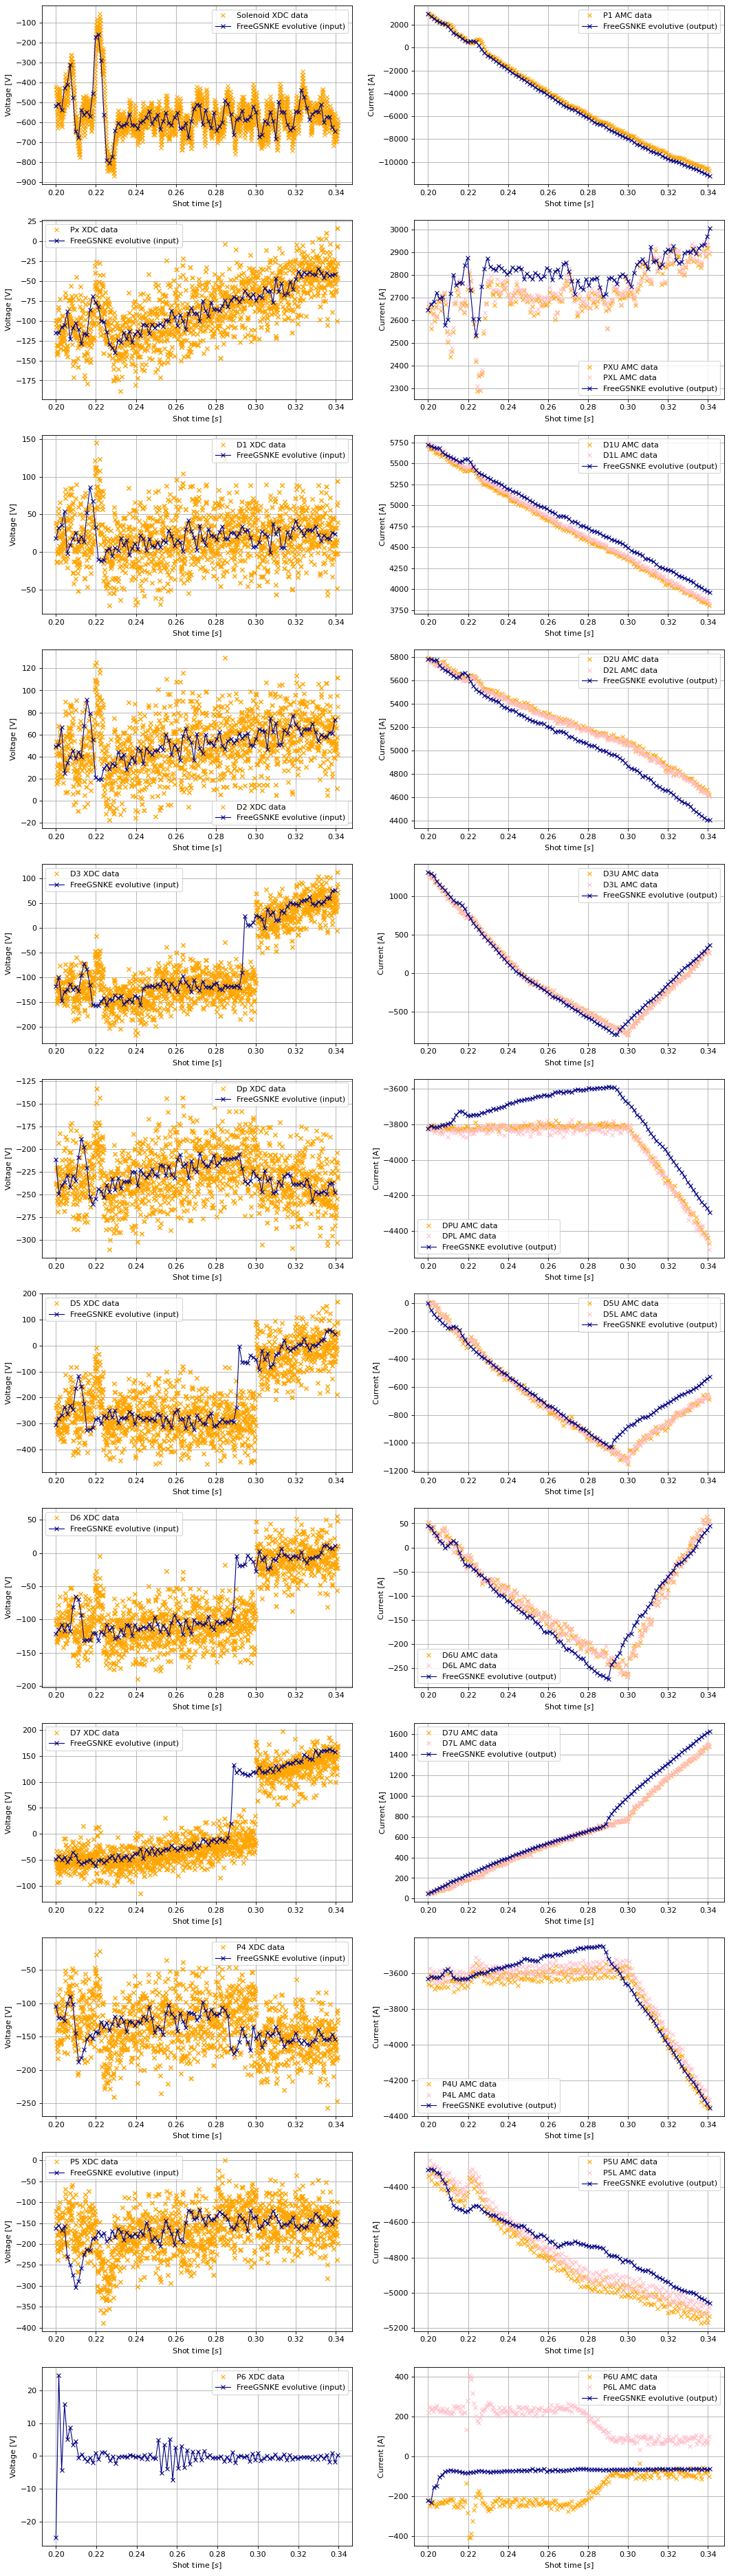

In [ ]:
# some coils have voltages with signs the incorrect way (these are MAST-U specific)
voltage_signs = np.array([1,1,1,1,1,1,1,1,1,-1,-1,1])
    
plt.figure(figsize=(16,60), dpi=80)

for j, coil in enumerate(coil_names):
    
    ax1 = plt.subplot(12,2,(j+1)*2-1)
    data_times = np.linspace(data[coil]['full_time'][0], data[coil]['full_time'][1], data[coil]['full_time'][2])
    mask = (data_times >= min(history_times))*(data_times <= max(history_times))
    ax1.plot(data_times[mask], voltage_signs[j]*data[coil]['fullV'][mask], color='orange',  linewidth=0, marker='x', markersize=5, label=coil+' XDC data')
    ax1.plot(history_times[0:-1], history_voltages[:,j], color='navy',  linewidth=1, marker='x', markersize=5, label="FreeGSNKE evolutive (input)")
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel(r'Shot time [$s$]')
    ax1.set_ylabel(r'Voltage [V]')
    ax1.legend()

    ax2 = plt.subplot(12,2,(j+1)*2)
    cols = ['orange', 'pink']
    for i, rog in enumerate(att_dict[coil]['rogextn']):
        data_times = np.linspace(data[coil][rog]['full_time_C'][0], data[coil][rog]['full_time_C'][1], data[coil][rog]['full_time_C'][2])
        mask = (data_times >= min(history_times))*(data_times <= max(history_times))
        ax2.plot(data_times[mask], 1e3*data[coil][rog]['fullC'][mask], color=cols[i],  linewidth=0, marker='x', markersize=5, label=rog+' AMC data')
    ax2.plot(history_times, history_full_currents[:,j], color='navy',  linewidth=1, marker='x', markersize=5, label="FreeGSNKE evolutive (output)")
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel(r'Shot time [$s$]')
    ax2.set_ylabel(r'Current [A]')
    ax2.legend()

### Shape targets

Here, we plot comparisons between the evolutive simulation and the static simulations we performed above. We compare the inner ($R_{in}$) and outer ($R_{out}$) midplane raddi, the magnetic axis position ($R_{m}$ and $Z_{m}$), the lower X-point ($R_{x}$ and $Z_{x}$), and the lower outer strikepoint ($R_{s}$ and $Z_{s}$). 

In [ ]:
# calculate targets from evolutive solves above
history_Rin_Rout = np.array([eq.innerOuterSeparatrix() for eq in history_eqs])
history_RZ_mag = np.array([eq.magneticAxis()[0:2] for eq in history_eqs])
history_Xpoint = np.array([eq.xpt[:2][np.argsort(eq.xpt[:2,1])][0,:2] for eq in history_eqs])
history_strikepoint = np.array([eq.strikepoints()[np.argsort(eq.strikepoints()[:,1])][0,:] for eq in history_eqs])

# calculate targets from static solves above
static_Rin_Rout = np.array([freegsnke_output_data[name][0].innerOuterSeparatrix() for name in freegsnke_output_data])
static_RZ_mag = np.array([freegsnke_output_data[name][0].magneticAxis()[0:2] for name in freegsnke_output_data])
static_Xpoint = np.array([freegsnke_output_data[name][0].xpt[:2][np.argsort(freegsnke_output_data[name][0].xpt[:2,1])][0,:2] for name in freegsnke_output_data])
static_strikepoint = np.array([
    freegsnke_output_data[name][0].strikepoints()[np.argsort(freegsnke_output_data[name][0].strikepoints()[:, 1])][0, :]
    if freegsnke_output_data[name][0].strikepoints() is not None else np.full((2,), np.nan)  # Adjust shape as needed
    for name in freegsnke_output_data
])


ValueError: x and y must have same first dimension, but have shapes (101,) and (1,)

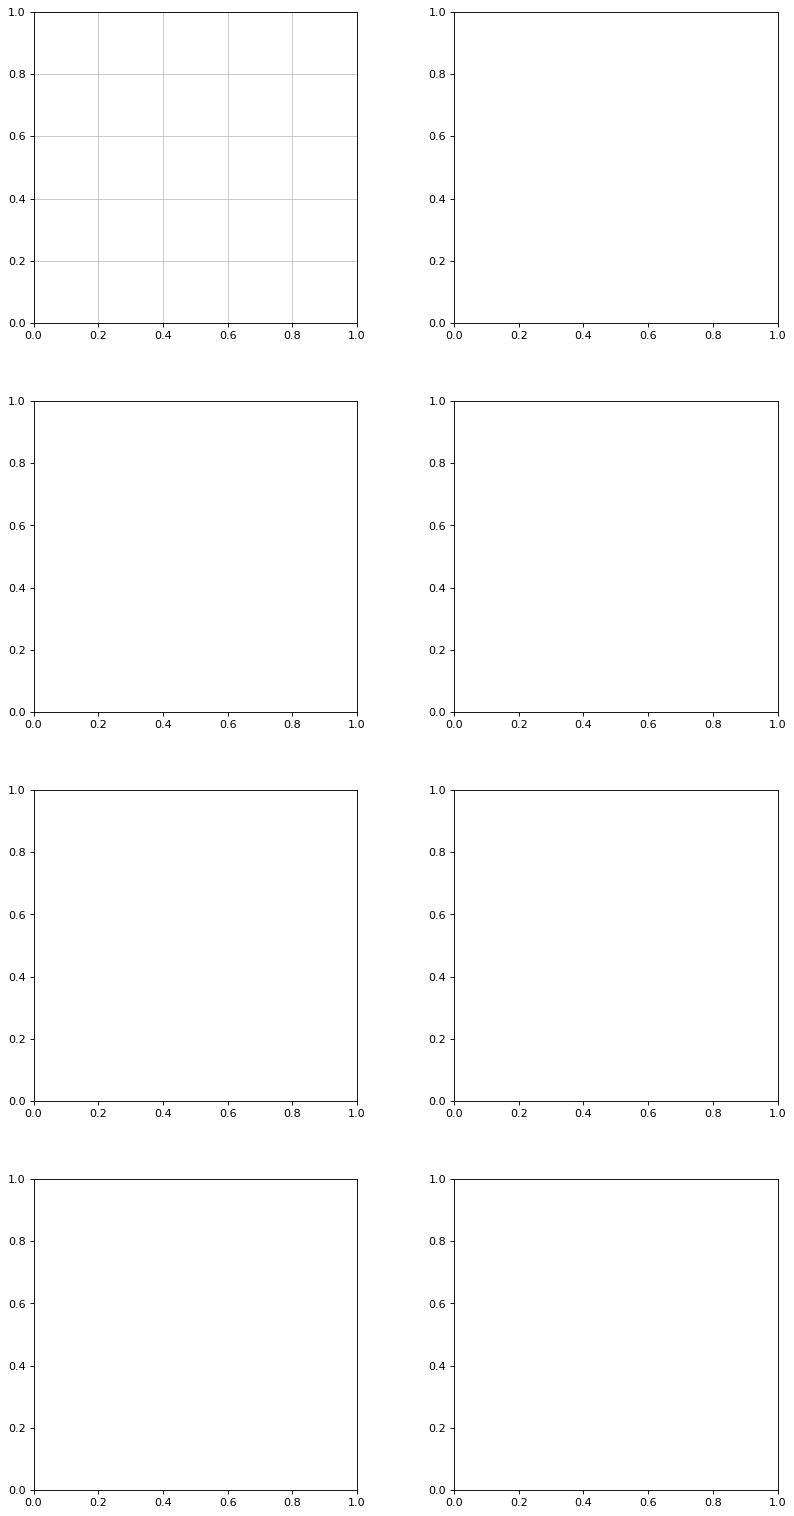

In [ ]:
# plots
fig1, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(12, 24), dpi=80)
plt.subplots_adjust(wspace=0.3, hspace=0.25)

ax1.grid(zorder=0, alpha=0.75)
ax1.plot(history_times, history_Rin_Rout[:,0], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax1.plot(times, static_Rin_Rout[:,0], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax1.set_ylabel(r'$R_{in}$ [$m$]')
ax1.set_xlabel(r'Shot time [$s$]')
ax1.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax1.set_axisbelow(True)

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(history_times, history_Rin_Rout[:,1], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax2.plot(times, static_Rin_Rout[:,1], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax2.set_ylabel(r'$R_{out}$ [$m$]')
ax2.set_xlabel(r'Shot time [$s$]')
ax2.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax2.set_axisbelow(True)

ax3.grid(zorder=0, alpha=0.75)
ax3.plot(history_times, history_RZ_mag[:,0], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax3.plot(times, static_RZ_mag[:,0], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax3.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax3.set_xlabel(r'Shot time [$s$]')
ax3.set_ylabel(r'$R_{m}$ [$m$]')
ax3.set_axisbelow(True)

ax4.grid(zorder=0, alpha=0.75)
ax4.plot(history_times, history_RZ_mag[:,1], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax4.plot(times, static_RZ_mag[:,1], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax4.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax4.set_xlabel(r'Shot time [$s$]')
ax4.set_ylabel(r'$Z_{m}$ [$m$]')
ax4.set_axisbelow(True)

ax5.grid(zorder=0, alpha=0.75)
ax5.plot(history_times, history_Xpoint[:,0], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax5.plot(times, static_Xpoint[:,0], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax5.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax5.set_xlabel(r'Shot time [$s$]')
ax5.set_ylabel(r'$R_{x}$ [$m$]')
ax5.set_axisbelow(True)

ax6.grid(zorder=0, alpha=0.75)
ax6.plot(history_times, history_Xpoint[:,1], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax6.plot(times, static_Xpoint[:,1], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax6.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax6.set_xlabel(r'Shot time [$s$]')
ax6.set_ylabel(r'$Z_{x}$ [$m$]')
ax6.set_axisbelow(True)

ax7.grid(zorder=0, alpha=0.75)
ax7.plot(history_times, history_strikepoint[:,0], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax7.plot(times, static_strikepoint[:,0], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax7.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax7.set_xlabel(r'Shot time [$s$]')
ax7.set_ylabel(r'$R_{s}$ [$m$]')
ax7.set_axisbelow(True)

ax8.grid(zorder=0, alpha=0.75)
ax8.plot(history_times, history_strikepoint[:,1], color='navy',  linewidth=1, marker='x', markersize=5, label='FreeGSNKE evolutive (output)', zorder=10) 
ax8.plot(times, static_strikepoint[:,1], color='red',  linewidth=0, marker='x', markersize=5, label='FreeGSNKE static (output)', zorder=10) 
ax8.set_xlim([min(history_times)-0.001, max(history_times)+0.001])
ax8.set_xlabel(r'Shot time [$s$]')
ax8.set_ylabel(r'$Z_{s}$ [$m$]')
ax8.set_axisbelow(True)

plt.show()

In [ ]:
# save some of the data
results = {}
results['times'] = history_times
results['voltages'] = history_voltages
results['resistivities'] = history_plasma_resistivity

with open('evolutive_simulation_output_{shot}.pickle', 'wb') as handle:
    pickle.dump(results, handle)